# Create context-specific models using REDS RBC Omics data
## Setup
### Import packages

In [1]:
from collections import defaultdict
import re
import gurobipy as gp
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib_venn as mpl_venn
import numpy as np
import pandas as pd
import seaborn as sns
import sympy
from rbc_gem_utils import (
    COBRA_CONFIGURATION,
    get_dirpath,
    read_cobra_model,
    show_versions,
    write_cobra_model,
)
from rbc_gem_utils.analysis.overlay import (
    ProteinDilution,
    add_relaxation_budget,
    load_overlay_model,
    update_slack_value,
)
from rbc_gem_utils.util import AVOGADRO_NUMBER, DEFAULT_DRY_MASS_PER_CELL
from sklearn.metrics import r2_score

gp.setParam("OutputFlag", 0)
gp.setParam("LogToConsole", 0)

# Show versions of notebook
show_versions()

Set parameter Username

Package Information
-------------------
rbc-gem-utils 0.0.1

Dependency Information
----------------------
beautifulsoup4                       4.12.3
bio                                   1.6.2
cobra                                0.29.0
depinfo                               2.2.0
kaleido                               0.2.1
matplotlib                            3.8.2
memote                               0.17.0
networkx                              3.2.1
notebook                              7.0.7
openpyxl                              3.1.2
pandas                                2.2.0
pre-commit                            3.6.0
pyvis                                 0.3.2
rbc-gem-utils[database,network,vis] missing
requests                             2.31.0
scipy                                1.12.0
seaborn                              0.13.2

Build Tools Information
-----------------------
pip        23.3.1
setuptools 68.2.2
wheel      0.41.2

Platform Informat

### Define configuration
#### COBRA Configuration

In [2]:
COBRA_CONFIGURATION.solver = "gurobi"
COBRA_CONFIGURATION.bounds = (-1e8, 1e8)
COBRA_CONFIGURATION

Attribute,Description,Value
solver,Mathematical optimization solver,gurobi
tolerance,"General solver tolerance (feasibility, integrality, etc.)",1e-07
lower_bound,Default reaction lower bound,-100000000.0
upper_bound,Default reaction upper bound,100000000.0
processes,Number of parallel processes,15
cache_directory,Path for the model cache,/Users/zhaiman/Library/Caches/cobrapy
max_cache_size,Maximum cache size in bytes,104857600
cache_expiration,Model cache expiration time in seconds (if any),None


## Define organism, model, and dataset

In [3]:
organism = "Human"
model_id = "RBC_GEM"
dataset_name = "REDS_RBCOmics"

## Load RBC-GEM model

In [4]:
valid_organisms = {"Human", "Mouse"}
if organism not in valid_organisms:
    raise ValueError(f"Organism must be one of the following: {valid_organisms}")

# Set paths
proteomics_dirpath = (get_dirpath("proteomics", use_temp="raw") / organism / dataset_name).resolve()
overlay_dirpath = (get_dirpath("analysis") / "OVERLAY" / organism).resolve()
model_dirpath = overlay_dirpath / model_id

results_dirpath = (get_dirpath(use_temp="processed") / model_id / "OVERLAY" / organism / dataset_name).resolve()
fitting_dirpath = results_dirpath / "fitting"
sample_pcmodels_dirpath = results_dirpath / "sample_pcmodels"
# Ensure directories exist
results_dirpath.mkdir(exist_ok=True, parents=True)
fitting_dirpath.mkdir(exist_ok=True)
sample_pcmodels_dirpath.mkdir(exist_ok=True)

# Identify hemoglobin proteins
if organism == "Mouse":
    hemoglobin_proteins = {
        k.replace("-", "_"): v
        for k, v in {
            'Hba': "P01942",     # Hemoglobin subunit alpha
            'Hba-a1': "P01942",        
            'Hbb-b1': "P02088",  # Hemoglobin subunit beta-1
            'Hbb-b2': "P02089",  # Hemoglobin subunit beta-2
            'Hbb-bh0': "P04443", # Hemoglobin subunit beta-H0
            'Hbb-bh1': "P04444", # Hemoglobin subunit beta-H1
            'Hbz': "P06467",     # Hemoglobin subunit zeta
            'Hba-x': "P06467",
            'Hbz1': "P06467",   
            'Hbb-y': "P02104",   # Hemoglobin subunit epsilon-Y2
        }.items()
    }
else:
    hemoglobin_proteins = {
        "HBA": "P69905",    # Hemoglobin subunit alpha
        "HBB": "P68871",    # Hemoglobin subunit beta
        "HBD": "P02042",    # Hemoglobin subunit delta
        "HBE1": "P02100",   # Hemoglobin subunit beta
        "HBG1": "P69891",   # Hemoglobin subunit gamma-1
        "HBG2": "P69892",   # Hemoglobin subunit gamma-2
        "HBM": "Q6B0K9",    # Hemoglobin subunit mu
        "HBQ1": "P09105",   # Hemoglobin subunit theta-1
        "HBZ": "P02008",    # Hemoglobin subunit zeta
    }

# Load models
model = read_cobra_model(filename=model_dirpath / f"{model_id}.xml")
pcmodel = load_overlay_model(filename=model_dirpath / f"{model_id}_PC.xml")

pcmodel

Name,RBC_GEM_PC
Memory address,156ccca50
Number of metabolites,10410
Number of reactions,18799
Number of genes,820
Number of groups,78
Objective expression,1.0*NaKt - 1.0*NaKt_reverse_db47e
Compartments,"cytosol, extracellular space, protein compartment"


### Set figure options

In [5]:
save_figures = True
transparent = False
imagetype = "svg"

## Load data
#### Set variables for columns keys 

In [6]:
sample_key = "SAMPLE ID"
donor_key = "PUBLIC DONOR ID"
time_key = "DAY"

# For sample IDs
time_abbrev = "D"

### Load copy numbers and protein data

In [7]:
# Load protein copy numbers
df_copy_numbers = pd.read_csv(
    proteomics_dirpath / f"{dataset_name}_CopyNumbers.tsv",
    sep="\t",
    index_col=None
)
# Create sample IDs from donor and time points, then set as index
df_copy_numbers.index = pd.Index(
    df_copy_numbers[[donor_key, time_key]].apply(
        lambda x: f"{x[donor_key]}_{time_abbrev}{x[time_key]}",
        axis=1).values,
    name=sample_key
)

# Load protein data
df_protein_data = pd.read_csv(
    proteomics_dirpath / f"{dataset_name}_ProteinData.tsv",
    sep="\t",
    index_col="Entry",
)



donor_ids = list(df_copy_numbers[donor_key].unique())
timepoints = list(df_copy_numbers[time_key].unique())

print(f"Number of donors: {len(donor_ids)}")
print(f"Number of timepoints: {len(timepoints)}")

df_copy_numbers = df_copy_numbers.loc[df_copy_numbers[df_protein_data.index].dropna(axis=0, how="all").index]
sample_ids = list(df_copy_numbers.index.unique())
print(f"Number of samples: {len(sample_ids)}")

df_copy_numbers

Number of donors: 610
Number of timepoints: 3
Number of samples: 1830


,PUBLIC DONOR ID,DAY,A0A075B6I0,A0A075B6I9,A0A075B6J9,A0A075B6K4,A0A075B6K5,A0A075B6R2,A0A075B6S5,A0A075B6S9,...,Q9Y639,Q9Y666,Q9Y696,Q9Y6B6,Q9Y6B7,Q9Y6E0,Q9Y6I3,Q9Y6M4,Q9Y6M5,Q9Y6R7
SAMPLE ID,,,,,,,,,,,,,,,,,,,,,
S001_D10,S001,10,114518.643899,63113.250142,17612.721227,1033.70001,250738.681069,0.000000,8828.312669,0.000000,...,1392.454161,0.000000,19954.371068,74758.901488,0.000000,7907.492758,4904.162257,0.000000,8864.838390,4551.934758
S001_D23,S001,23,83733.413360,17891.485645,0.000000,0.00000,225441.984974,0.000000,28274.865365,138922.828686,...,933.842764,0.000000,11790.361238,0.000000,0.000000,8105.404114,31344.509782,5002.350276,8154.842476,4346.295603
S001_D42,S001,42,124576.860801,51427.456139,64512.914721,0.00000,232622.665201,0.000000,26229.595680,0.000000,...,2177.042354,161.034294,11937.380407,80634.321987,1094.445937,11943.564971,4265.520169,5596.879103,6604.146775,4345.806113
S002_D10,S002,10,0.000000,0.000000,0.000000,0.00000,246593.949891,10651.008268,22270.446851,0.000000,...,3323.982341,0.000000,21133.854588,46229.818435,0.000000,11718.406394,0.000000,0.000000,23386.405820,5267.201961
S002_D23,S002,23,52980.619738,0.000000,415956.112710,0.00000,443011.906351,0.000000,0.000000,0.000000,...,2508.714731,4267.543219,17838.394210,6541.070445,0.000000,16618.381242,0.000000,0.000000,24665.939736,1729.727805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S609_D23,S609,23,0.000000,0.000000,0.000000,0.00000,225635.007425,0.000000,9092.998956,0.000000,...,3673.791044,0.000000,7148.104570,124188.370607,0.000000,8157.254438,3839.757297,6371.901194,15905.183729,2299.903991
S609_D42,S609,42,0.000000,0.000000,0.000000,0.00000,138221.840018,0.000000,4613.159040,0.000000,...,3465.156142,0.000000,7107.225657,60512.211739,0.000000,9264.103912,10641.041401,897037.392699,13430.857197,3605.287383
S610_D10,S610,10,52483.854665,0.000000,16017.273082,0.00000,149738.028981,14758.092712,10439.649393,39609.443748,...,3964.128687,0.000000,0.000000,22176.084986,0.000000,10180.734600,6533.999663,7128.257654,7239.240669,1943.954949


### Load metadata and/or phenotype data

In [8]:
donor_index = pd.Index(df_copy_numbers[donor_key].unique(), name=donor_key)
cuts = {
    "BMI": [0, 25, 30, 40, 60],
    "Age": [0, 20, 40, 60, 80, 100],
}
try:
    df_meta = pd.read_csv(
        proteomics_dirpath / f"{dataset_name}_MetaData.tsv",
        sep="\t",
        index_col=[donor_key],
    ).convert_dtypes()
except FileNotFoundError:
    df_meta = pd.DataFrame([], index=donor_index)
else:
    for col, bins in cuts.items():
        labels = []
        for idx in range(1, len(bins)):
            if idx == 1 or idx == len(bins) - 1:
                labels += [f"lt{bins[idx]}"]
            elif idx :
                labels += [f"gt{bins[idx - 1]}"]
            else:
                labels += [f"{bins[idx - 1]}to{bins[idx]}"]
        df_meta[col] = pd.cut(df_meta[col], bins=bins, labels=labels, right=False)
    df_meta = df_meta.select_dtypes(exclude="number")

try:
    df_phenotype = pd.read_csv(
        proteomics_dirpath / f"{dataset_name}_Phenotypes.tsv",
        sep="\t",
        index_col=[donor_key],
    ).convert_dtypes()
except FileNotFoundError:
    df_phenotype = pd.DataFrame([], index=donor_index)
else:
    df_meta = df_meta.merge(df_phenotype, left_index=True, right_index=True, how="left")
df_meta

,AS,Gender,DONDB.ABO_RH,RBCOmics.Race.Ethnicity.Group,Age,BMI,G6PD_ALLELES
PUBLIC DONOR ID,,,,,,,
S001,AS1,M,O+,CAUCASIAN,gt20,gt25,0
S002,AS3,M,A+,HIGH,gt60,gt25,0
S003,AS1,F,O+,HIGH,gt40,lt25,0
S004,AS1,F,A+,CAUCASIAN,gt40,lt25,0
S005,AS1,M,A+,OTHER,gt40,gt30,0
...,...,...,...,...,...,...,...
S647,AS1,F,O+,HIGH,lt100,gt30,0
S648,AS1,F,A+,HIGH,gt60,lt25,0
S649,AS1,F,A-,CAUCASIAN,gt60,lt25,0


#### Load MCH data

In [9]:
mch_default = {
    "Human": DEFAULT_DRY_MASS_PER_CELL,
    "Mouse": 13.9
}
try:
    df_MCH_per_sample = pd.read_csv(
        proteomics_dirpath / f"{dataset_name}_MCH.tsv",
        sep="\t",
        index_col=None
    )
except FileNotFoundError:
    df_MCH_per_sample = pd.DataFrame(
        [mch_default[organism]] * len(df_copy_numbers.index), 
        index=df_copy_numbers.index,
        columns=["MCH"],
    )
    df_MCH_per_sample[donor_key] = df_copy_numbers[donor_key]
    df_MCH_per_sample[time_key] = df_copy_numbers[time_key]
else:
    # Create sample IDs from donor and time points
    df_MCH_per_sample.index = pd.Index(
        df_MCH_per_sample[[donor_key, time_key]].apply(
            lambda x: f"{x[donor_key]}_{time_abbrev}{x[time_key]}",
            axis=1).values,
        name=sample_key
    )

df_MCH_per_sample

,PUBLIC DONOR ID,MCH,DAY
SAMPLE ID,,,
S001_D10,S001,29.080675,10
S001_D23,S001,29.080675,23
S001_D42,S001,29.080675,42
S002_D10,S002,30.669145,10
S002_D23,S002,30.669145,23
...,...,...,...
S609_D23,S609,28.942116,23
S609_D42,S609,28.942116,42
S610_D10,S610,29.025424,10


### Get data subsets using operations

In [10]:
operations = [
    "mean", 
    "median",
]
operation_dfs = []
operation_dfs_MCH = []
to_fill = set()
operation_ids_dict = defaultdict(set)

df_weighting_mat = df_copy_numbers.copy()
operation_dfs_weights = []

#### Group by donor only

In [11]:
key = donor_key
prefix_value = ""
df_data = df_copy_numbers.copy()
df_MCH = df_MCH_per_sample.copy()
df_weights = df_weighting_mat.copy()
for op in operations:
    df = df_data.groupby([key], as_index=False, observed=False)[df_protein_data.index]
    df = getattr(df, op.lower())()
    labels = df[[key]].apply(
        lambda x: "_".join([
            f"{prefix_value}{x[key]}" 
        ]), 
        axis=1
    )
    labels = [f"{op.capitalize()}_{value}" for value in labels]
    operation_ids_dict[key].update(labels)
    df.index = pd.Index(labels, name=sample_key)
    operation_dfs += [df.reset_index(drop=False)]

    # Apply same transformation to MCH
    df = df_MCH.groupby([key], as_index=False, observed=False)["MCH"]
    df = getattr(df, op.lower())()
    df.index = pd.Index(labels, name=sample_key)
    operation_dfs_MCH += [df.reset_index(drop=False)]

    # Apply same transformation to weighting matrix
    df = df_weights.groupby(list([key]), as_index=False, observed=False)[df_protein_data.index]
    df = getattr(df, op.lower())()
    df.index = pd.Index(labels, name=sample_key)
    operation_dfs_weights += [df.reset_index(drop=False)]

#### Group by time only

In [12]:
key = time_key
prefix_value = time_abbrev
df_data = df_copy_numbers.copy()
df_MCH = df_MCH_per_sample.copy()
df_weights = df_weighting_mat.copy()
for op in operations:
    df = df_data.groupby([key], as_index=False, observed=False)[df_protein_data.index]
    df = getattr(df, op.lower())()
    labels = df[[key]].apply(
        lambda x: "_".join([
            f"{prefix_value}{x[key]}" 
        ]), 
        axis=1
    )
    labels = [f"{op.capitalize()}_{value}" for value in labels]
    operation_ids_dict[key].update(labels)
    df.index = pd.Index(labels, name=sample_key)
    operation_dfs += [df.reset_index(drop=False)]

    # Apply same transformation to MCH
    df = df_MCH.groupby([key], as_index=False, observed=False)["MCH"]
    df = getattr(df, op.lower())()
    df.index = pd.Index(labels, name=sample_key)
    operation_dfs_MCH += [df.reset_index(drop=False)]

    # Apply same transformation to weighting matrix
    df = df_weights.groupby(list([key]), as_index=False, observed=False)[df_protein_data.index]
    df = getattr(df, op.lower())()
    df.index = pd.Index(labels, name=sample_key)
    operation_dfs_weights += [df.reset_index(drop=False)]

#### Group by metadata/phenotype only
##### By phenotype

In [13]:
all_group_keys_prefixes = {
    "G6PD_ALLELES": "G6PD_ALLELES_",
    "Gender": "Sex_",
    "BMI": "BMI_",
    "Age": "Age_",
}

df_data = df_copy_numbers.merge(
    df_meta[[x for x in list(all_group_keys_prefixes) if x not in {donor_key, time_key}]],
    left_on=donor_key,
    right_index=True,
    how="left"
).convert_dtypes()
df_MCH = df_MCH_per_sample.merge(
    df_meta[[x for x in list(all_group_keys_prefixes) if x not in {donor_key, time_key}]],
    left_on=donor_key,
    right_index=True,
    how="left"
).convert_dtypes()
df_weights = df_weighting_mat.merge(
    df_meta[[x for x in list(all_group_keys_prefixes) if x not in {donor_key, time_key}]],
    left_on=donor_key,
    right_index=True,
    how="left"
).convert_dtypes()

for key, prefix_value in all_group_keys_prefixes.items():
    for op in operations:
        df = df_data.groupby([key], as_index=False, observed=False)[df_protein_data.index]
        df = getattr(df, op.lower())()
        labels = df[[key]].apply(
            lambda x: "_".join([
                f"{prefix_value}{x[key]}" 
            ]), 
            axis=1
        )
        labels = [f"{op.capitalize()}_{value}" for value in labels]
        operation_ids_dict[key].update(labels)
        df.index = pd.Index(labels, name=sample_key)
        operation_dfs += [df.reset_index(drop=False)]
    
        # Apply same transformation to MCH
        df = df_MCH.groupby([key], as_index=False, observed=False)["MCH"]
        df = getattr(df, op.lower())()
        df.index = pd.Index(labels, name=sample_key)
        operation_dfs_MCH += [df.reset_index(drop=False)]

        # Apply same transformation to weighting matrix
        df = df_weights.groupby(list([key]), as_index=False, observed=False)[df_protein_data.index]
        df = getattr(df, op.lower())()
        df.index = pd.Index(labels, name=sample_key)
        operation_dfs_weights += [df.reset_index(drop=False)]
        
    to_fill.add(key)

### Add to DataFrame of copy numbers

In [14]:
if operation_dfs:
    df_operations = pd.concat(operation_dfs, axis=0)
    df_operations = df_operations.drop_duplicates()
    df_operations = df_operations.set_index(sample_key)
else:
    df_operations = pd.DataFrame()
df_data = pd.concat((df_copy_numbers, df_operations), axis=0)

if operation_dfs_MCH:
    df_operations_MCH = pd.concat(operation_dfs_MCH, axis=0)
    df_operations_MCH = df_operations_MCH.drop_duplicates()
    df_operations_MCH = df_operations_MCH.set_index(sample_key)
else:
    df_operations_MCH = pd.DataFrame()
df_data_MCH = pd.concat((df_MCH_per_sample, df_operations_MCH), axis=0)


if operation_dfs_weights:
    df_operations_weights = pd.concat(operation_dfs_weights, axis=0)
    df_operations_weights = df_operations_weights.drop_duplicates()
    df_operations_weights = df_operations_weights.set_index(sample_key)
else:
    df_operations_weights = pd.DataFrame()
df_data_weights = pd.concat((df_weighting_mat, df_operations_weights), axis=0)


for fill_key in to_fill:
    fill_dict = df_meta[fill_key].to_dict()
    df_data[fill_key] = df_data[[donor_key, fill_key]].apply(lambda x: fill_dict.get(x[donor_key], x[fill_key]), axis=1)
operation_ids_dict = {k: sorted(v) for k, v in operation_ids_dict.items()}

df_data_MCH = df_data_MCH["MCH"].squeeze()
df_data

,PUBLIC DONOR ID,DAY,A0A075B6I0,A0A075B6I9,A0A075B6J9,A0A075B6K4,A0A075B6K5,A0A075B6R2,A0A075B6S5,A0A075B6S9,...,Q9Y6B7,Q9Y6E0,Q9Y6I3,Q9Y6M4,Q9Y6M5,Q9Y6R7,G6PD_ALLELES,Gender,BMI,Age
SAMPLE ID,,,,,,,,,,,,,,,,,,,,,
S001_D10,S001,10.0,114518.643899,63113.250142,17612.721227,1033.70001,250738.681069,0.0,8828.312669,0.0,...,0.0,7907.492758,4904.162257,0.0,8864.83839,4551.934758,0,M,gt25,gt20
S001_D23,S001,23.0,83733.41336,17891.485645,0.0,0.0,225441.984974,0.0,28274.865365,138922.828686,...,0.0,8105.404114,31344.509782,5002.350276,8154.842476,4346.295603,0,M,gt25,gt20
S001_D42,S001,42.0,124576.860801,51427.456139,64512.914721,0.0,232622.665201,0.0,26229.59568,0.0,...,1094.445937,11943.564971,4265.520169,5596.879103,6604.146775,4345.806113,0,M,gt25,gt20
S002_D10,S002,10.0,0.0,0.0,0.0,0.0,246593.949891,10651.008268,22270.446851,0.0,...,0.0,11718.406394,0.0,0.0,23386.40582,5267.201961,0,M,gt25,gt60
S002_D23,S002,23.0,52980.619738,0.0,415956.11271,0.0,443011.906351,0.0,0.0,0.0,...,0.0,16618.381242,0.0,0.0,24665.939736,1729.727805,0,M,gt25,gt60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Median_Age_lt20,NaN,NaN,46339.840839,0.0,21041.130155,0.0,296244.31146,0.0,0.0,0.0,...,0.0,8051.707403,2374.92822,3219.400624,11060.906581,3516.614402,<NA>,<NA>,NaN,lt20
Median_Age_gt20,NaN,NaN,92055.428155,0.0,31310.652906,0.0,304633.040772,1495.596995,21710.742308,23406.680501,...,0.0,10194.233636,2947.931493,860.279399,10216.741053,2551.09501,<NA>,<NA>,NaN,gt20
Median_Age_gt40,NaN,NaN,91958.355124,0.0,28466.751588,0.0,292999.729704,1055.218069,18743.470315,0.0,...,0.0,10488.514322,3010.673482,0.0,11178.045535,2802.831267,<NA>,<NA>,NaN,gt40


## Integrate proteomics with model
### Convert copy numbers to mg / gDW

In [15]:
df_uniprot_to_mw = df_protein_data["Mass"] / 1000  # g/mol --> # kg / mol
df_mg_prot_per_gDW = (
    df_data[df_protein_data.index].mul(
        1 / df_data_MCH, # cell / pgDW
        axis=0
    )
    * (1e12 / 1)  # pgDW / gDW
    * (1 / AVOGADRO_NUMBER)  # mol / protein copies
    * (df_uniprot_to_mw)  # kg / mol
    * (1e6 / 1)  # mg / kg
).copy()
df_mg_prot_per_gDW = df_mg_prot_per_gDW.loc[df_data.index]
df_mg_prot_per_gDW

,A0A075B6I0,A0A075B6I9,A0A075B6J9,A0A075B6K4,A0A075B6K5,A0A075B6R2,A0A075B6S5,A0A075B6S9,A0A087WSY6,A0A0A0MRZ8,...,Q9Y639,Q9Y666,Q9Y696,Q9Y6B6,Q9Y6B7,Q9Y6E0,Q9Y6I3,Q9Y6M4,Q9Y6M5,Q9Y6R7
SAMPLE ID,,,,,,,,,,,,,,,,,,,,,
S001_D10,0.083793,0.044933,0.012483,0.000734,0.176563,0.0,0.006408,0.0,0.231702,0.044519,...,0.003529,0.0,0.032783,0.095664,0.0,0.022264,0.016884,0.0,0.027992,0.148679
S001_D23,0.061267,0.012738,0.0,0.0,0.15875,0.0,0.020524,0.100649,0.231575,0.046045,...,0.002367,0.0,0.019371,0.0,0.0,0.022821,0.107913,0.014679,0.02575,0.141962
S001_D42,0.091152,0.036613,0.045723,0.0,0.163806,0.0,0.019039,0.0,0.219781,0.06155,...,0.005518,0.001095,0.019612,0.103183,0.005203,0.033628,0.014685,0.016423,0.020854,0.141946
S002_D10,0.0,0.0,0.0,0.0,0.164651,0.007409,0.015328,0.0,0.0,0.007605,...,0.007988,0.0,0.032923,0.056093,0.0,0.031285,0.0,0.0,0.070022,0.163131
S002_D23,0.036758,0.0,0.279535,0.0,0.295799,0.0,0.0,0.0,0.0,0.0,...,0.006029,0.027521,0.027789,0.007937,0.0,0.044366,0.0,0.0,0.073853,0.053572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Median_Age_lt20,0.033945,0.0,0.01493,0.0,0.208844,0.0,0.0,0.0,0.024816,0.044516,...,0.00649,0.0,0.023878,0.026807,0.0,0.022696,0.008186,0.009458,0.034967,0.114993
Median_Age_gt20,0.066478,0.0,0.021902,0.0,0.211717,0.001083,0.015554,0.016737,0.030022,0.055407,...,0.004882,0.0,0.022347,0.014128,0.0,0.028328,0.010017,0.002491,0.031841,0.08224
Median_Age_gt40,0.065902,0.0,0.019761,0.0,0.202079,0.000758,0.013326,0.0,0.0,0.050119,...,0.004911,0.0,0.02488,0.021566,0.0,0.028924,0.010152,0.0,0.034571,0.089666


### Scale measurements for proteome budget
Note that this step will help ensure its theoretically possible for a perfect fit 

In [16]:
la_proteome_budget_value = 50
hemoglobin_budget_value = 950
total_budget_value = None

In [17]:
# Split into hemoglobin and low abundance proteomes
df_mg_prot_per_gDW_hb = df_mg_prot_per_gDW.loc[:, df_mg_prot_per_gDW.columns.isin(hemoglobin_proteins.values())]
df_mg_prot_per_gDW_la = df_mg_prot_per_gDW.loc[:, ~df_mg_prot_per_gDW.columns.isin(hemoglobin_proteins.values())]

df_summary = {
    "Perfect total": 1000,
    "Current total": df_mg_prot_per_gDW.loc[sample_ids].sum(axis=1).mean().item(),
    "Hemoglobin total": df_mg_prot_per_gDW_hb.loc[sample_ids].sum(axis=1).mean().item(),
    "Low abundance total": df_mg_prot_per_gDW_la.loc[sample_ids].sum(axis=1).mean().item(),
}
df_summary["Remaining/Excess"] = df_summary["Perfect total"] - (
    df_summary["Hemoglobin total"] + df_summary["Low abundance total"]
)

PBDL_proteome_budget = pcmodel.reactions.get_by_id("PBDL_proteome_budget")
PBDL_hemoglobin_budget = pcmodel.reactions.get_by_id("PBDL_hemoglobin_budget")
PBDL_total_budget = pcmodel.reactions.get_by_id("PBDL_total_budget")

if la_proteome_budget_value is None:
    la_proteome_budget_value = PBDL_proteome_budget.upper_bound
if hemoglobin_budget_value is None:
    hemoglobin_budget_value = PBDL_hemoglobin_budget.upper_bound
if total_budget_value is None:
    total_budget_value = PBDL_total_budget.upper_bound

assert total_budget_value >= (la_proteome_budget_value + hemoglobin_budget_value)

PBDL_proteome_budget.upper_bound = la_proteome_budget_value
PBDL_hemoglobin_budget.upper_bound = hemoglobin_budget_value
PBDL_total_budget.upper_bound = total_budget_value

# Scale values for low abundance proteome
budget_value = la_proteome_budget_value
df_mg_prot_per_gDW_la = (
    budget_value * (df_mg_prot_per_gDW_la.T / df_mg_prot_per_gDW_la.sum(axis=1)).T
)
df_summary["Low abundance scaled"] = budget_value

# Scale values for hemoglobin proteome
budget_value = hemoglobin_budget_value
df_mg_prot_per_gDW_hb = (
    budget_value * (df_mg_prot_per_gDW_hb.T / df_mg_prot_per_gDW_hb.sum(axis=1)).T
)
df_summary["Hemoglobin scaled"] = budget_value

budget_value = total_budget_value - sum(
    [la_proteome_budget_value, hemoglobin_budget_value]
)
df_summary["Remaining scaled"] = budget_value

# Combine dataframes back into one
df_mg_prot_per_gDW_normalized = pd.concat(
    (df_mg_prot_per_gDW_hb, df_mg_prot_per_gDW_la), axis=1
)
df_summary = pd.DataFrame.from_dict(
    {
        " " * max(30 - len(k), 0) + k: [f"{v:.4f}", f"{v / 1000 * 100:.1f}%"]
        for k, v in df_summary.items()
    },
    orient="index",
    columns=["mg protein / gDW / cell", "Percentage"],
)
print(df_summary)
df_mg_prot_per_gDW_normalized.sum(axis=1)

                     mg protein / gDW / cell Percentage
       Perfect total               1000.0000     100.0%
       Current total               1000.0000     100.0%
    Hemoglobin total                429.4023      42.9%
 Low abundance total                570.5977      57.1%
    Remaining/Excess                  0.0000       0.0%
Low abundance scaled                 50.0000       5.0%
   Hemoglobin scaled                950.0000      95.0%
    Remaining scaled                  0.0000       0.0%


SAMPLE ID
S001_D10            1000.0
S001_D23            1000.0
S001_D42            1000.0
S002_D10            1000.0
S002_D23            1000.0
                     ...  
Median_Age_lt20     1000.0
Median_Age_gt20     1000.0
Median_Age_gt40     1000.0
Median_Age_gt60     1000.0
Median_Age_lt100    1000.0
Length: 3084, dtype: Float64

### Convert mg / gDW to nmol / gDW

In [18]:
df_nmol_prot_per_gDW = (
    df_mg_prot_per_gDW_normalized  # mg / gDW
    * (1 / df_uniprot_to_mw)  # mol / kg --> mmol / g --> umol / mg
    * (1e3 / 1)  # nmol / umol
).loc[:, df_mg_prot_per_gDW_normalized.columns]
df_nmol_prot_per_gDW = df_nmol_prot_per_gDW.T
df_nmol_prot_per_gDW

SAMPLE ID,S001_D10,S001_D23,S001_D42,S002_D10,S002_D23,S002_D42,S003_D10,S003_D23,S003_D42,S004_D10,...,Mean_Age_lt20,Mean_Age_gt20,Mean_Age_gt40,Mean_Age_gt60,Mean_Age_lt100,Median_Age_lt20,Median_Age_gt20,Median_Age_gt40,Median_Age_gt60,Median_Age_lt100
P02008,5711.701488,6195.993951,8202.371061,10030.992827,9267.072179,9577.94476,7761.886683,9585.442147,7386.126355,7139.463629,...,6714.035851,7166.279485,7340.989021,7148.414655,7059.18386,5455.888859,7520.411111,7579.114147,7518.276852,7901.307668
P02042,23598.528519,23922.365911,15256.582852,27625.580957,27930.313499,25892.111687,23732.280301,18498.546948,30364.640014,15743.006155,...,22597.290079,23832.136406,24192.108082,24437.314172,24039.8115,23878.602338,23863.043012,24499.467624,24528.047038,24860.822862
P02100,2.705134,3.509404,7.697601,4.510245,289.081171,6.809605,17.970784,4.306167,8.942239,4.0576,...,9.724694,23.369428,21.961602,30.233086,6.653502,9.382095,6.102469,6.258832,5.565218,6.107899
P09105,38.067281,36.529563,42.859252,60.526125,81.707715,52.171248,29.875331,41.622117,38.394597,34.410908,...,44.369946,42.330502,41.164461,40.770749,40.066531,43.482057,42.203442,40.798517,40.735003,38.357214
P68871,9503.146391,10031.605421,11963.335657,5453.197068,5092.491052,6879.143103,9390.955205,11351.03009,9217.85899,11122.192261,...,11041.262761,10309.161569,10166.06932,10441.737139,10567.518642,11552.609554,10140.517225,10100.376502,10371.909546,10201.162528
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9Y6E0,0.038086,0.040313,0.054938,0.062468,0.090008,0.072397,0.045219,0.05556,0.068864,0.04255,...,0.03925,0.053056,0.053893,0.055228,0.061306,0.042058,0.0533,0.054358,0.057661,0.058927
Q9Y6I3,0.023621,0.155896,0.01962,0.0,0.0,0.0,0.029578,0.0,0.0,0.016981,...,0.019487,0.01998,0.017633,0.017456,0.018367,0.012405,0.015413,0.015603,0.015263,0.016644
Q9Y6M4,0.0,0.02488,0.025744,0.0,0.0,0.0,0.0,0.035888,0.0,0.027049,...,0.152217,0.130699,0.151264,0.139048,0.106719,0.016816,0.004498,0.0,0.0,0.025591
Q9Y6M5,0.042697,0.040559,0.030378,0.124667,0.133595,0.114644,0.050889,0.081279,0.107624,0.036415,...,0.052595,0.053939,0.05925,0.058221,0.047702,0.057776,0.053418,0.057932,0.05866,0.051531


## Create DataFrame for protein dilution reactions

In [19]:
df_model_protein_dilutions = pd.concat(
    (
        pd.Series(
            {g.annotation.get("uniprot"): g.id for g in model.genes}, name="genes"
        ),
        pd.Series(
            {
                protdl.annotation.get("uniprot"): protdl.id
                for protdl in pcmodel.reactions.query(
                    lambda x: isinstance(x, ProteinDilution)
                )
            },
            name="PROTDL",
        ),
    ),
    axis=1,
)
df_model_protein_dilutions.index.name = "uniprot"
df_model_protein_dilutions = df_model_protein_dilutions[
    df_model_protein_dilutions["genes"].isin(model.genes.list_attr("id"))
].sort_values("PROTDL")
df_model_protein_dilutions

,genes,PROTDL
uniprot,,
Q9NPC4,A4GALT,PROTDL_protein_A4GALT_pc
P49588,AARS1,PROTDL_protein_AARS1_pc
Q9NRN7,AASDHPPT,PROTDL_protein_AASDHPPT_pc
O95477,ABCA1,PROTDL_protein_ABCA1_pc
Q8IZY2,ABCA7,PROTDL_protein_ABCA7_pc
...,...,...
P07947,YES1,PROTDL_protein_YES1_pc
Q5W0Z9,ZDHHC20,PROTDL_protein_ZDHHC20_pc
Q9UIJ5,ZDHHC2,PROTDL_protein_ZDHHC2_pc


## Organize samples (optional)
Use this for organizing samples if time-outs are an issue or multiple runs are necessary

In [20]:
df_samples = df_nmol_prot_per_gDW.copy()

# Use this line of code to determine which samples are used.
# Useful for picking up where notebook may have prematurely stopped.
# Set as length of donor IDs to use all samples
sample_interval = (0, len(donor_ids))
# Set as 0 or less to use only operation samples
# sample_interval = (0, 0)
# Set as timepoints to use all time points
sample_times = timepoints.copy()
# Set as empty to use no time point data
# sample_times = []
# Split sample IDs and operation IDs
include_operations = [
    # 'PUBLIC DONOR ID', 
    'DAY', 
    # 'Gender', 
    # 'BMI', 
    # 'G6PD_ALLELES'
]
# Use line below to get all samples formed from operations (e.g., mean, median)
# include_operations = list(operation_ids_dict)

operation_ids = [op_id for key, op_ids_list in operation_ids_dict.items() for op_id in sorted(op_ids_list) if key in include_operations]



def get_sample_from_id(x, sample_re):
    sample = sample_re.search(x)
    if sample:
        return int(sample.group("sample"))
    else:
        return False

sample_re = re.compile("\S(?P<sample>\d\d\d)")
sample_ids = [
    x for x in sample_ids 
    if get_sample_from_id(x, sample_re) # Not an operation ID
    and sample_interval[0] <= get_sample_from_id(x, sample_re) <= sample_interval[1] # Within interval
]
operation_ids = [
    x for x in operation_ids 
    if not get_sample_from_id(x, sample_re) # Another operation ID not involving samples
    or sample_interval[0] <= get_sample_from_id(x, sample_re) <= sample_interval[1]  # Within interval
]


def get_time_from_id(x, time_re):
    time = time_re.search(x)
    if time:
        return int(time.group("time"))
    else:
        return False

time_re = re.compile(f"{time_abbrev}(?P<time>\d+)")
sample_ids = [
    x for x in sample_ids 
    if get_time_from_id(x, time_re) # Not an opereation ID
    and get_time_from_id(x, time_re) in sample_times # Within timepoints
]
operation_ids = [
    x for x in operation_ids 
    if not get_time_from_id(x, time_re) # Another operation ID not involving timepoints
    or get_time_from_id(x, time_re) in sample_times # Within timepoints
]

# Filter out irrelevant samples
df_samples = df_samples.loc[:, sample_ids + operation_ids]
df_samples

SAMPLE ID,S001_D10,S001_D23,S001_D42,S002_D10,S002_D23,S002_D42,S003_D10,S003_D23,S003_D42,S004_D10,...,S609_D42,S610_D10,S610_D23,S610_D42,Mean_D10,Mean_D23,Mean_D42,Median_D10,Median_D23,Median_D42
P02008,5711.701488,6195.993951,8202.371061,10030.992827,9267.072179,9577.94476,7761.886683,9585.442147,7386.126355,7139.463629,...,9554.927289,1850.776929,7539.056552,1421.186546,7254.171962,7191.161305,7276.125424,7570.116373,7476.973198,7577.939784
P02042,23598.528519,23922.365911,15256.582852,27625.580957,27930.313499,25892.111687,23732.280301,18498.546948,30364.640014,15743.006155,...,15580.189785,21864.215813,20037.847845,21482.26338,24319.561164,24124.046239,24073.204773,24438.485147,24426.11943,24294.680416
P02100,2.705134,3.509404,7.697601,4.510245,289.081171,6.809605,17.970784,4.306167,8.942239,4.0576,...,10.828917,4.584667,1.431378,4.406774,26.784603,24.112027,22.684754,6.24307,5.861416,5.869179
P09105,38.067281,36.529563,42.859252,60.526125,81.707715,52.171248,29.875331,41.622117,38.394597,34.410908,...,59.383256,53.742123,48.93848,59.159458,41.80878,40.869249,41.293183,40.887376,41.190034,40.940012
P68871,9503.146391,10031.605421,11963.335657,5453.197068,5092.491052,6879.143103,9390.955205,11351.03009,9217.85899,11122.192261,...,12764.616739,14447.172279,9381.567841,17321.920077,10262.502125,10248.28329,10344.217365,10168.886163,10093.613763,10248.933157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9Y6E0,0.038086,0.040313,0.054938,0.062468,0.090008,0.072397,0.045219,0.05556,0.068864,0.04255,...,0.043612,0.04898,0.036313,0.033781,0.054817,0.053605,0.053757,0.055661,0.054653,0.054698
Q9Y6I3,0.023621,0.155896,0.01962,0.0,0.0,0.0,0.029578,0.0,0.0,0.016981,...,0.050095,0.031435,0.013015,0.027986,0.021783,0.017271,0.015374,0.01929,0.014337,0.012757
Q9Y6M4,0.0,0.02488,0.025744,0.0,0.0,0.0,0.0,0.035888,0.0,0.027049,...,4.222957,0.034294,0.024984,0.016275,0.137418,0.134361,0.156402,0.0,0.0,0.0
Q9Y6M5,0.042697,0.040559,0.030378,0.124667,0.133595,0.114644,0.050889,0.081279,0.107624,0.036415,...,0.063228,0.034828,0.043135,0.041588,0.056653,0.057919,0.05827,0.05738,0.056758,0.057551


### Map samples to model

In [21]:
merge_key = "uniprot"
df_samples.index.name = merge_key

df_model = (
    df_model_protein_dilutions[["PROTDL"]]
    .merge(df_samples, left_index=True, right_index=True, how="left")
    .set_index("PROTDL")
    .sort_index()
)
no_experimental_measurements = [
    protein_dilution
    for protein_dilution, has_measurement in df_model.isna().all(axis=1).items()
    if has_measurement
]
print(
    f"Model proteins mapped to measurements: {len(df_model) - len(no_experimental_measurements)}"
)
print(f"Model proteins without measurements: {len(no_experimental_measurements)}")
df_model.dropna()

Model proteins mapped to measurements: 524
Model proteins without measurements: 296


,S001_D10,S001_D23,S001_D42,S002_D10,S002_D23,S002_D42,S003_D10,S003_D23,S003_D42,S004_D10,...,S609_D42,S610_D10,S610_D23,S610_D42,Mean_D10,Mean_D23,Mean_D42,Median_D10,Median_D23,Median_D42
PROTDL,,,,,,,,,,,,,,,,,,,,,
PROTDL_protein_AARS1_pc,0.016548,0.016056,0.02291,0.039456,0.030369,0.037975,0.019119,0.008683,0.005173,0.010755,...,0.013004,0.013325,0.013941,0.01905,0.02345,0.023007,0.022629,0.022912,0.022846,0.022434
PROTDL_protein_AASDHPPT_pc,0.105539,0.094642,0.106604,0.02318,0.0,0.0,0.0,0.0,0.0,0.111859,...,0.0,0.029472,0.043749,0.0,0.011302,0.014236,0.009493,0.0,0.0,0.0
PROTDL_protein_ABCB6_pc,0.157586,0.141928,0.132416,0.094033,0.095336,0.104518,0.176915,0.086452,0.065404,0.139074,...,0.244628,0.126121,0.167983,0.152676,0.138961,0.137605,0.139101,0.143539,0.143568,0.146168
PROTDL_protein_ABCC1_pc,0.014914,0.014828,0.027336,0.0,0.0,0.0,0.013321,0.045371,0.0,0.017636,...,0.024819,0.014227,0.017264,0.01431,0.023269,0.023177,0.02398,0.018586,0.020683,0.020776
PROTDL_protein_ABCC4_pc,0.042641,0.04625,0.03721,0.056579,0.054304,0.045073,0.051173,0.046281,0.06915,0.051205,...,0.079712,0.0375,0.056196,0.046514,0.053876,0.053662,0.053455,0.056682,0.056172,0.05602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PROTDL_protein_WDR77_pc,0.468144,0.489826,0.485841,0.494281,0.520838,0.477451,0.442753,0.389425,0.37623,0.528052,...,0.595779,0.515413,0.602775,0.539221,0.465451,0.470854,0.467087,0.489648,0.490252,0.489539
PROTDL_protein_WNK1_pc,0.047562,0.055109,0.052594,0.025514,0.037551,0.015743,0.047097,0.049747,0.019674,0.058304,...,0.045948,0.036403,0.054117,0.038883,0.03933,0.040162,0.039591,0.04058,0.042469,0.041362
PROTDL_protein_XPNPEP1_pc,0.110483,0.109043,0.108751,0.1154,0.152629,0.0898,0.117508,0.1227,0.117942,0.096528,...,0.102349,0.108766,0.112095,0.090995,0.125469,0.124195,0.12253,0.128446,0.127196,0.125684


#### Summarize mapping

In [22]:
dataset_proteins = set(df_samples.index)
model_proteins = set(df_model_protein_dilutions.index)

df_mg_prot_per_gDW_hb = df_mg_prot_per_gDW_normalized.loc[
    [x for x in df_mg_prot_per_gDW_normalized.index if x in sample_ids], # Don't include operation IDs
    [x for x in df_mg_prot_per_gDW_normalized.columns if x in list(hemoglobin_proteins.values())]]
df_mg_prot_per_gDW_la = df_mg_prot_per_gDW_normalized.loc[
    [x for x in df_mg_prot_per_gDW_normalized.index if x in sample_ids], # Don't include operation IDs
    [x for x in df_mg_prot_per_gDW.columns if not x in list(hemoglobin_proteins.values())]
]

df_mapped_mass_la = df_mg_prot_per_gDW_la.loc[
    :, df_mg_prot_per_gDW_la.columns.isin(model_proteins)
].sum(axis=1)
df_unmapped_mass_la = df_mg_prot_per_gDW_la.loc[
    :, ~df_mg_prot_per_gDW_la.columns.isin(model_proteins)
].sum(axis=1)
df_mapped_mass_hb = df_mg_prot_per_gDW_hb.loc[
    :, df_mg_prot_per_gDW_hb.columns.isin(model_proteins)
].sum(axis=1)
df_unmapped_mass_hb = df_mg_prot_per_gDW_hb.loc[
    :, ~df_mg_prot_per_gDW_hb.columns.isin(model_proteins)
].sum(axis=1)

proteomes = {}
round_int = 6
for label, df in zip(
    ["hemoglobin", "low abundance"], [df_mg_prot_per_gDW_hb, df_mg_prot_per_gDW_la]
):
    df_modeled = df.loc[:, df.columns.isin(model_proteins)].sum(axis=1)
    df_remaining = df.loc[:, ~df.columns.isin(model_proteins)].sum(axis=1)
    means = (df_modeled.mean(), df_remaining.mean())
    stdevs = (df_modeled.std(), df_remaining.std())
    proteomes[(label, "modeled")] = round(means[0], round_int)
    proteomes[(label, "remaining")] = round(means[1], round_int)
proteomes = pd.Series(proteomes, name="Mean value across samples")
proteomes.index = [f"Mean {k[0]} mass {k[1]}" for k in proteomes.index]
print(proteomes.head())
proteomes = proteomes[proteomes != 0]

Mean hemoglobin mass modeled         950.000000
Mean hemoglobin mass remaining         0.000000
Mean low abundance mass modeled       25.266957
Mean low abundance mass remaining     24.733043
Name: Mean value across samples, dtype: float64


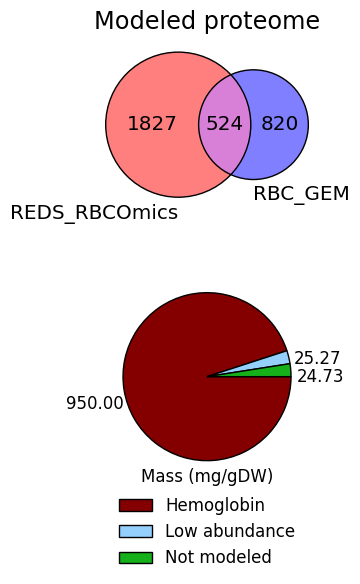

In [23]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(3, 6))
subsets = (
    len(dataset_proteins),
    len(model_proteins),
    len(dataset_proteins.intersection(model_proteins)),
)


venn = mpl_venn.venn2(
    subsets=subsets,
    set_labels=(dataset_name, model.id),
    set_colors=("red", "blue"),
    alpha=0.5,
    ax=ax1,
)
circles = mpl_venn.venn2_circles(
    subsets=subsets, linestyle="-", color="black", ax=ax1, linewidth=1
)
for text in venn.set_labels:
    text.set_fontsize("x-large")
for text in venn.subset_labels:
    text.set_fontsize("x-large")
ax1.set_title("Modeled proteome", fontsize="xx-large")


label_color_map = {
    "Mean hemoglobin mass modeled": ("Hemoglobin", "xkcd:dark red"),
    "Mean low abundance mass modeled": ("Low abundance", "xkcd:light blue"),
    "Mean low abundance mass remaining": ("Not modeled", "xkcd:green"),
}
edgecolor = "black"
linewidth = 1
ax2.pie(
    x=proteomes.values,
    colors=[label_color_map[k][1] for k in proteomes.index],
    pctdistance=1.35,
    counterclock=False,
    autopct=lambda pct: f"{pct * 1000/100:.2f}\n",
    textprops=dict(fontsize="large", ha="center", va="top"),
    wedgeprops=dict(edgecolor=edgecolor, linewidth=linewidth),
)
handles = [
    mpl.patches.Patch(
        edgecolor=edgecolor,
        linewidth=linewidth,
        label=label_color_map[k][0],
        facecolor=label_color_map[k][1],
    )
    for k in proteomes.index
]
ax2.legend(
    handles=handles,
    ncols=1,
    bbox_to_anchor=(0.5, 0),
    loc="upper center",
    fontsize="large",
    frameon=False,
)
ax2.set_xlabel("Mass (mg/gDW)", fontsize="large", labelpad=-10)
if save_figures:
    fig.savefig(
        results_dirpath / f"ModeledProteome.{imagetype}",
        transparent=transparent,
        format=imagetype,
    )
fig;

## Create QP model for each sample

In [24]:
def solve_qp(pcmodel, df):
    x = []  # Variables
    c = []  # Data * Weights
    F = []  # Weights

    for protdl, (data_value, weight) in df.iterrows():
        protdl = pcmodel.reactions.get_by_id(protdl)
        x.append(protdl.flux_expression)
        c.append(weight * data_value)
        F.append(weight)

    x = sympy.Matrix(x)
    c = sympy.Matrix(c)
    F = sympy.DiagMatrix(sympy.Matrix(F))
    # # QP Objective must be in form of 0.5 * x.T * F * x - c.T * x
    objective = 0.5 * x.T * F * x - c.T * x
    pcmodel.objective = objective[0]
    pcmodel.objective_direction = "min"
    pcmodel.tolerance = 1e-9

    qp_sol = pcmodel.optimize()
    return qp_sol


def solve_qp_for_samples(pcmodel, df_samples, df_weights=None, log_zero_replacement=1e-6, verbose=False):
    qp_solutions_dict = {}
    for sample_id, data_series in df_samples.items():
        # Get protein values
        data_series.name = "Data"
        if df_weights is None:
            data_weights = 1 / data_series.replace(0, 1)
            data_weights = data_weights / data_weights.mean()
        else:
            data_weights = df_weights.loc[:, sample_id]
        # Get protein weights
        data_weights.name = "Weights"

        # Map to model, currently model mapping DataFrame generated outside scope of function
        df_model_data_weights = (
            df_model_protein_dilutions[["PROTDL"]]
            .merge(data_series, left_index=True, right_index=True, how="left")
            .merge(data_weights, left_index=True, right_index=True, how="left")
            .set_index("PROTDL")
            .sort_index()
        )

        df = df_model_data_weights.loc[:, [data_series.name, data_weights.name]].dropna(
            axis=0, how="all"
        ).astype(float)

        with pcmodel:
            qp_sol = solve_qp(pcmodel, df)

        df_qp_sol = qp_sol.fluxes.loc[
            pcmodel.reactions.query(lambda x: isinstance(x, ProteinDilution)).list_attr(
                "id"
            )
        ]
        df_qp_sol = (
            pd.concat((df_model_data_weights, df_qp_sol), axis=1).dropna().sort_index()
        )
        # data_weights = df_qp_sol.loc[:, "Weights"]

        df_qp_sol = df_qp_sol.rename(
            {"Data": "Measured Proteome", "fluxes": "Best-Fitted Proteome"}, axis=1
        )
        df_qp_sol = df_qp_sol.loc[:, ["Measured Proteome", "Best-Fitted Proteome"]]

        r2 = r2_score(
            df_qp_sol.iloc[:, 0].values,
            df_qp_sol.iloc[:, 1].values,
            multioutput="uniform_average",
        )
        r2_log10 = r2_score(
            df_qp_sol.iloc[:, 0].apply(lambda x: log_zero_replacement if np.isclose(x, 0) else x).apply(np.log10).values,
            df_qp_sol.iloc[:, 1].apply(lambda x: log_zero_replacement if np.isclose(x, 0) else x).apply(np.log10).values,
            multioutput="uniform_average",
        )
        qp_solutions_dict[sample_id] = (df_qp_sol, r2, r2_log10, qp_sol.objective_value)
        if verbose:
            # Recall that the objective is designed to try to minimize fitting error via maximizing R2, so 1 is a possibility
            print(
                "R^2 and log10 R^2 (objective) value for Sample '{}': {:.9f} and {:.9f} ({:.5f})".format(
                    sample_id, r2, r2_log10, qp_sol.objective_value
                )
            )
        # TODO catch bad fits

    return qp_solutions_dict

### Set weightings for QP problem

In [25]:
# Ensure data is provided as (Protein IDs x Sample IDs)
# Use original copy number values for weights
df_weights = df_data_weights.T.loc[df_protein_data.index, df_samples.columns]
df_weights = 1 / df_weights.infer_objects(copy=False).replace(0, 1)
df_weights /= df_weights.mean()
df_weights

SAMPLE ID,S001_D10,S001_D23,S001_D42,S002_D10,S002_D23,S002_D42,S003_D10,S003_D23,S003_D42,S004_D10,...,S609_D42,S610_D10,S610_D23,S610_D42,Mean_D10,Mean_D23,Mean_D42,Median_D10,Median_D23,Median_D42
Entry,,,,,,,,,,,,,,,,,,,,,
A0A075B6I0,0.000053,0.000070,0.000053,3.505007,0.000057,0.000036,0.000118,0.000110,2.921928,0.000157,...,4.622793,0.000090,0.000123,0.000026,0.015139,0.015635,0.009197,0.000057,0.000060,0.000059
A0A075B6I9,0.000097,0.000329,0.000128,3.505007,3.028857,3.901922,5.775953,4.075971,2.921928,6.710474,...,4.622793,4.741966,6.661566,3.419735,0.147514,0.123787,0.091669,4.854628,4.960501,4.803891
A0A075B6J9,0.000347,5.888330,0.000102,3.505007,0.000007,3.901922,5.775953,4.075971,2.921928,6.710474,...,4.622793,0.000296,6.661566,3.419735,0.018925,0.020525,0.010735,0.000158,0.000206,0.000164
A0A075B6K4,0.005906,5.888330,6.565146,3.505007,3.028857,3.901922,5.775953,4.075971,2.921928,6.710474,...,4.622793,4.741966,6.661566,3.419735,4.645463,8.246848,4.174206,4.854628,4.960501,4.803891
A0A075B6K5,0.000024,0.000026,0.000028,0.000014,0.000007,0.000006,0.000050,0.000015,0.000016,0.000017,...,0.000033,0.000032,0.000072,0.000022,0.004248,0.004393,0.002589,0.000016,0.000017,0.000016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9Y6E0,0.000772,0.000726,0.000550,0.000299,0.000182,0.000278,0.000605,0.000342,0.000276,0.000684,...,0.000499,0.000466,0.000832,0.000491,0.134597,0.138457,0.084174,0.000455,0.000470,0.000458
Q9Y6I3,0.001245,0.000188,0.001539,3.505007,3.028857,3.901922,0.000925,4.075971,2.921928,0.001714,...,0.000434,0.000726,0.002322,0.000593,0.338710,0.429744,0.294323,0.001314,0.001791,0.001963
Q9Y6M4,6.105322,0.001177,0.001173,3.505007,3.028857,3.901922,5.775953,0.000530,2.921928,0.001076,...,0.000005,0.000665,0.001210,0.001020,0.053692,0.055240,0.028931,4.854628,4.960501,4.803891


In [26]:
run_computations = False
log_zero_replacement = 1e-9
fitting_data = {"measured": {}, "best_fit": {}, "r2_objective": {}}
if run_computations:
    qp_solutions_dict = solve_qp_for_samples(
        pcmodel, df_samples, df_weights=df_weights, log_zero_replacement=log_zero_replacement, verbose=True
    )

    for sample_id, (df_qp_sol, r2, r2_log10, objective_value) in qp_solutions_dict.items():
        fitting_data["measured"][sample_id] = df_qp_sol["Measured Proteome"].to_dict()
        fitting_data["best_fit"][sample_id] = df_qp_sol[
            "Best-Fitted Proteome"
        ].to_dict()
        fitting_data["r2_objective"][sample_id] = {
            "R2": r2,
            "log10_R2": r2_log10,
            "Objective": objective_value,
        }
    for key, data in fitting_data.items():
        data = pd.DataFrame.from_dict(data, orient="columns")
        data.to_csv(fitting_dirpath / f"proteome_{key}.tsv", sep="\t", index=True)
        fitting_data[key] = data
else:
    for key in fitting_data.keys():
        fitting_data[key] = pd.read_csv(
            fitting_dirpath / f"proteome_{key}.tsv", sep="\t", index_col=0
        )
    qp_solutions_dict = {}
    for sample_id in df_samples.columns:
        df_qp_sol = pd.concat(
            (
                fitting_data["measured"].loc[:, sample_id],
                fitting_data["best_fit"].loc[:, sample_id],
            ),
            axis=1,
        )
        df_qp_sol.columns = ["Measured Proteome", "Best-Fitted Proteome"]
        r2, r2_log10, objective_value = fitting_data["r2_objective"].loc[:, sample_id].values
        qp_solutions_dict[sample_id] = (df_qp_sol, r2, r2_log10, objective_value)
print(f"Number of QP solutions: {len(qp_solutions_dict)}")

Number of QP solutions: 1836


### Plot fitting for the mean and median samples of each time point

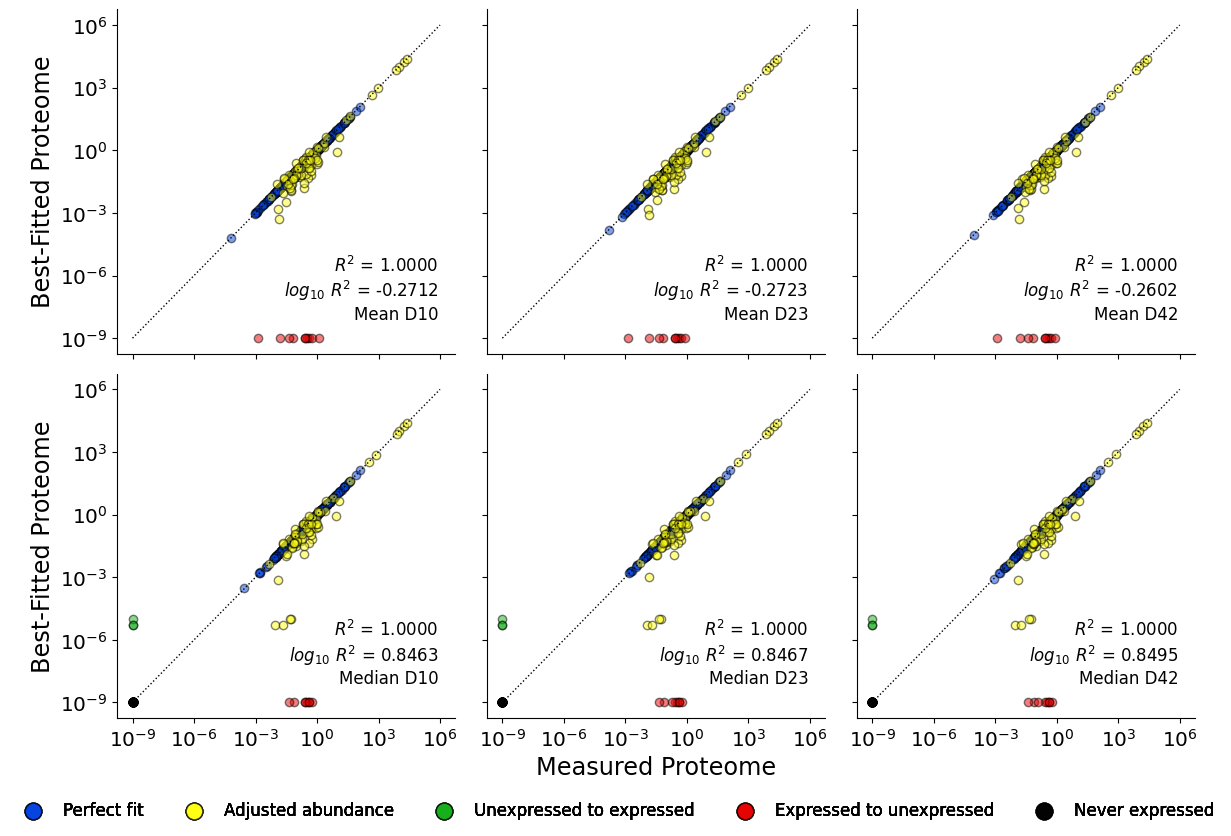

In [27]:
samples_to_plot = np.array(
    [
        # Best for 1 or 3 columns
        [x for x in operation_ids_dict[time_key] if "Mean" in x],
        [x for x in operation_ids_dict[time_key] if "Median" in x],
    ]
)

r2_text_loc = "lower right"
transform = False

length = 4
nrows, ncols = samples_to_plot.shape
fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(length * ncols, length * nrows),
    sharex=True,
    sharey=True,
)
sns.despine(fig)
for idx, (sample_id, ax) in enumerate(zip(samples_to_plot.flatten(), axes.flatten())):
    df_qp_sol, r2, r2_log10, objective_value = qp_solutions_dict[sample_id]
    # Copy to prevent alterations to the original
    df_qp_sol = df_qp_sol.copy()
    xlabel, ylabel = df_qp_sol.columns
    
    ticks = 10**np.arange(*np.log10([log_zero_replacement, 1e8]), 3)
    if transform:
        ticks = np.log10(ticks)
        df_qp_sol.iloc[:, 0] = df_qp_sol.iloc[:, 0].apply(lambda x: log_zero_replacement if np.isclose(x, 0) else x).apply(np.log10)
        df_qp_sol.iloc[:, 1] = df_qp_sol.iloc[:, 1].apply(lambda x: log_zero_replacement if np.isclose(x, 0) else x).apply(np.log10)
    perfect_fit_line = ax.plot(
        [ticks[0], ticks[-1]],
        [ticks[0], ticks[-1]],
        linestyle=":",
        color="black",
        linewidth=1,
        alpha=1,
    )

    zero_val = 0 if not transform else np.log10(log_zero_replacement)

    df_zeros = df_qp_sol[(df_qp_sol.apply(lambda x: np.isclose(x, zero_val))).any(axis=1)]
    df_perfect = df_qp_sol[
        np.isclose(
            abs(df_qp_sol["Measured Proteome"] - df_qp_sol["Best-Fitted Proteome"]), 0
        )
    ]
    df_perfect = df_perfect[~df_perfect.index.isin(df_zeros.index)]
    
    df_altered = df_qp_sol[
        ~np.isclose(
            abs(df_qp_sol["Measured Proteome"] - df_qp_sol["Best-Fitted Proteome"]), 0
        )
    ]
    df_altered = df_altered[~df_altered.index.isin(df_zeros.index)]
    df_always_zero = df_zeros[(df_zeros == zero_val).all(axis=1)]
    df_zeros = df_zeros[~df_zeros.index.isin(df_always_zero.index)]
    df_from_zeros = df_zeros[np.isclose(df_zeros["Measured Proteome"], zero_val)]
    df_to_zeros = df_zeros[np.isclose(df_zeros["Best-Fitted Proteome"], zero_val)]

    handles = [
        ax.scatter(
            data=df_perfect.replace(0, ticks[0]),
            x=xlabel,
            y=ylabel,
            color="xkcd:blue",
            alpha=0.5,
            edgecolors="black",
            linewidths=1,
        ),
        ax.scatter(
            data=df_altered.replace(0, ticks[0]),
            x=xlabel,
            y=ylabel,
            color="xkcd:yellow",
            alpha=0.5,
            edgecolors="black",
            linewidths=1,
        ),
        ax.scatter(
            data=df_from_zeros.replace(0, ticks[0]),
            x=xlabel,
            y=ylabel,
            color="xkcd:green",
            alpha=0.5,
            edgecolors="black",
            linewidths=1,
        ),
        ax.scatter(
            data=df_to_zeros.replace(0, ticks[0]),
            x=xlabel,
            y=ylabel,
            color="xkcd:red",
            alpha=0.5,
            edgecolors="black",
            linewidths=1,
        ),
        ax.scatter(
            data=df_always_zero.replace(0, ticks[0]),
            x=xlabel,
            y=ylabel,
            color="xkcd:black",
            alpha=0.5,
            edgecolors="black",
            linewidths=1,
        ),
    ]
    labels = [
        f"Perfect fit",
        f"Adjusted abundance",
        f"Unexpressed to expressed",
        f"Expressed to unexpressed",
        f"Never expressed",
    ]

    op, time = str(sample_id.replace(f"{pcmodel.id}_", "")).split("_")
    sample_label = " ".join((op, time))

    if not transform:
        ax.set_xscale("log")
        ax.set_yscale("log")

    fontdict = {"size": "xx-large"}
    if idx == len(samples_to_plot.flatten()) - np.ceil(ncols / 2):
        ax.set_xlabel(xlabel, fontdict=fontdict)
    fig.legend(
        handles=handles,
        labels=labels,
        loc="lower center",
        ncols=len(labels),
        frameon=False,
        fontsize="large",
        markerscale=2,
        bbox_to_anchor=(0.5, -0.05),
    )
    if idx % ncols == 0:
        ax.set_ylabel(ylabel, fontdict=fontdict)

    ax.set_xticks(ticks)
    ax.set_yticks(ticks)

    ax.xaxis.set_tick_params(labelsize="x-large")
    ax.yaxis.set_tick_params(labelsize="x-large")

    r2_format = " = {:.4f}"
    if r2_text_loc == "lower right":
        ax.text(
            0.95,
            0.1,
            "\n".join((r"$R^{2}$" + r2_format.format(r2), r"$log_{10}\ R^{2} $" + r2_format.format(r2_log10), sample_label)),
            transform=ax.transAxes,
            color="black",
            fontsize="large",
            ha="right",
        )
    elif r2_text_loc == "upper left":
        ax.text(
            0.05,
            0.9,
            "\n".join((r"$R^{2}$" + r2_format.format(r2), r"$log_{10}\ R^{2} $" + r2_format.format(r2_log10), sample_label)),
            transform=ax.transAxes,
            color="black",
            fontsize="large",
            ha="left",
        )
    else:
        pass
fig.tight_layout()
if save_figures:
    fig.savefig(
        fitting_dirpath / f"QPfitting_{'' if not transform else 'log10_'}{model_id}.{imagetype}",
        transparent=transparent,
        format=imagetype,
    )

### Determine best value for slack variables

In [28]:
list_of_pcmodels = []
verbose = True
objective_rxns = ["NaKt"]

slack_min = 1e-5  # Slack %
slack_max = 1.5
slack_determination_models = operation_ids_dict[time_key]
if run_computations:
    for sample_id in slack_determination_models:
        df_qp_sol, r2, r2_log10, objective_value = qp_solutions_dict[sample_id]
        # Create a copy of the model
        pcmodel_sample = pcmodel.copy()
        pcmodel_sample.id = f"{pcmodel.id}_{sample_id}"
        for protdl in pcmodel_sample.reactions.query(
            lambda x: isinstance(x, ProteinDilution)
        ):
            if protdl.id in df_qp_sol.index:
                prot_bound = df_qp_sol.loc[protdl.id]["Best-Fitted Proteome"]
            else:
                prot_bound = 0
            protdl.bounds = (float(prot_bound), float(prot_bound))
        # Add the relaxation budget with slack = 0 first
        add_relaxation_budget(pcmodel_sample, 0, int(verbose))
        list_of_pcmodels += [pcmodel_sample]

    solutions = {
        pcmodel_sample.id: {
            "model": [],
            "slack": [],
            "objective": [],
            "relaxation": [],
            "_".join(objective_rxns): [],
        }
        for pcmodel_sample in list_of_pcmodels
    }
    for slack_value in np.geomspace(slack_min, slack_max, 501):
        if int(verbose):
            print(f"Updating slack variable to {100 * slack_value:.6f}%.")
        for pcmodel_sample in list_of_pcmodels:
            update_slack_value(pcmodel_sample, slack_value, verbose=False)
            relaxation_demand = pcmodel_sample.reactions.get_by_id(
                f"PBDL_relaxation_budget"
            )
            pcmodel_sample.objective = (
                sum(
                    [
                        r.flux_expression
                        for r in pcmodel_sample.reactions.get_by_any(objective_rxns)
                    ]
                )
                - relaxation_demand.flux_expression
            )
            pcmodel_sample.objective_direction = "max"
            sol = pcmodel_sample.optimize()
            obj_value = sol.objective_value
            if not obj_value or np.isnan(obj_value):
                if int(verbose) > 1:
                    print(f"No solution for {100 * slack_value:.6f}%\n.")
                continue
            else:
                demand = relaxation_demand.flux
                budget = relaxation_demand.upper_bound
            solutions[pcmodel_sample.id]["model"].append(pcmodel_sample.id)
            solutions[pcmodel_sample.id]["slack"].append(slack_value)
            solutions[pcmodel_sample.id]["objective"].append(obj_value)
            solutions[pcmodel_sample.id]["_".join(objective_rxns)].append(
                obj_value + demand
            )
            solutions[pcmodel_sample.id]["relaxation"].append(demand / budget)
    solutions = {
        pcmodel_sample_id: pd.DataFrame.from_dict(sol)
        for pcmodel_sample_id, sol in solutions.items()
    }
    solutions = {
        pcmodel_sample: pd.DataFrame.from_dict(sol)
        for pcmodel_sample, sol in solutions.items()
    }

    df_relaxation = pd.concat(list(solutions.values()), axis=0)
    df_relaxation.to_csv(
        fitting_dirpath / f"SlackPercentDeterminationData_{model_id}.tsv",
        sep="\t",
        index=False,
    )
else:
    df_relaxation = pd.read_csv(
        fitting_dirpath / f"SlackPercentDeterminationData_{model_id}.tsv", sep="\t"
    )
    solutions = {
        mid: df_relaxation[df_relaxation["model"] == mid].drop("model", axis=1)
        for mid in df_relaxation["model"].unique()
    }
df_relaxation

,model,slack,objective,relaxation,NaKt
0,RBC_GEM_PC_Mean_D10,0.020061,-0.849103,0.048571,0.100477
1,RBC_GEM_PC_Mean_D10,0.020545,-0.847771,0.047360,0.100477
2,RBC_GEM_PC_Mean_D10,0.021040,-0.846385,0.046177,0.100477
3,RBC_GEM_PC_Mean_D10,0.021548,-0.844942,0.045021,0.100477
4,RBC_GEM_PC_Mean_D10,0.022068,-0.843442,0.043890,0.100477
...,...,...,...,...,...
1087,RBC_GEM_PC_Median_D42,1.363586,0.025675,0.000052,0.094861
1088,RBC_GEM_PC_Median_D42,1.396480,0.025675,0.000051,0.094861
1089,RBC_GEM_PC_Median_D42,1.430167,0.025675,0.000050,0.094861
1090,RBC_GEM_PC_Median_D42,1.464668,0.025675,0.000048,0.094861


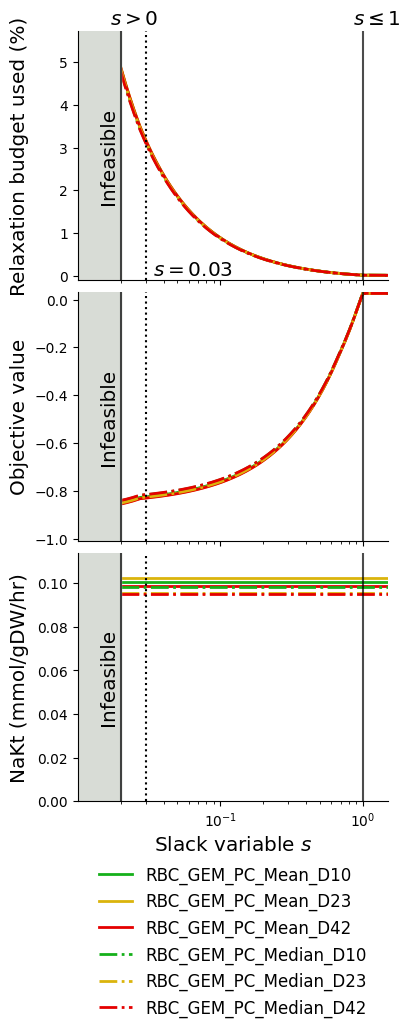

In [29]:
fig, axes = plt.subplots(
    3, 1, figsize=(4, 10), sharex=True, gridspec_kw=dict(hspace=0.05)
)
axes = axes.flatten()

# ax3d = fig.add_subplot(2, 2, 4, projection="3d")
sns.despine(fig)

handles = []
labels = []
chosen_slack_var = 0.03
colors = {
    "D10": "xkcd:green",
    "D23": "xkcd:gold",
    "D42": "xkcd:red",
}
linestyles = {
    "Mean": "-",
    "Median": "-.",
}
use_percents = True
for pcmodel_sample in list(solutions):
    donor, day = str(pcmodel_sample).split("_")[-2:]
    linestyle = linestyles.get(donor, ":")
    color = colors.get(day, "xkcd:light blue")
    if not ("Mean" == donor or "Median" == donor):
        donor = donor.replace("S", "; Donor ")
    day = day.replace("D", "Day ")
    fancy_sample_id = " ".join((day, donor))

    labels.append(fancy_sample_id)
    s_values = solutions[str(pcmodel_sample)]["slack"].values
    r_values = solutions[str(pcmodel_sample)]["relaxation"].values * (
        100 if use_percents else 1
    )
    o_values = solutions[str(pcmodel_sample)]["objective"].values
    rxn_values = solutions[str(pcmodel_sample)]["_".join(objective_rxns)].values

    zorder = 1
    lw = 2
    axes[0].plot(
        s_values,
        r_values,
        label=str(pcmodel_sample),
        color=color,
        linestyle=linestyle,
        linewidth=lw,
        zorder=zorder,
    )
    axes[1].plot(
        s_values,
        o_values,
        label=str(pcmodel_sample),
        color=color,
        linestyle=linestyle,
        linewidth=lw,
        zorder=zorder,
    )
    axes[2].plot(
        s_values,
        rxn_values,
        label=str(pcmodel_sample),
        color=color,
        linestyle=linestyle,
        linewidth=lw,
        zorder=zorder,
    )

    # index = list(s_values).index(s_values[s_values >= chosen_slack_var][0])
    # spt = s_values[index]
    # rpt = r_values[index]
    # opt = o_values[index]
    # rxnpt = rxn_values[index]
    # c = "black"
    # ls = ""
    # marker = "o"
    # markersize = 8
    # axes[0].plot(spt, rpt, color=c, linestyle=ls, marker=marker, markersize=markersize)
    # axes[1].plot(spt, opt, color=c, linestyle=ls, marker=marker, markersize=markersize)
    # axes[2].plot(spt, rxnpt, color=c, linestyle=ls, marker=marker, markersize=markersize)
    # ax3d.plot(spt, rpt, opt, color=c, linestyle=ls, marker=marker, markersize=markersize)
    # print(f"Elbow point for {pcmodel_sample}: ({spt:.5f}, {rpt:.5f}, {opt:.5f})")
fontdict = {"size": "x-large"}
axes[-1].set_xlabel(r"Slack variable $s$", fontdict=fontdict)

zorder = 2
alpha = 0.7
limit_pad_sclar = 1.2
smin = s_values[0]

for i, ax in enumerate(axes):
    if i == 0:
        ymin, ymax = (
            -0.001 * (100 if use_percents else 1),
            max(r_values) * limit_pad_sclar,
        )
    elif i == 1:
        ymin, ymax = (
            min(0, min(o_values)) * limit_pad_sclar,
            max(o_values) * limit_pad_sclar,
        )
    elif i == 2:
        ymin, ymax = (0, max(rxn_values) * limit_pad_sclar)
    else:
        pass
    ax.vlines(chosen_slack_var, ymin=ymin, ymax=ymax, color="black", linestyle=":")
    ax.vlines(
        smin,
        ymin=ymin,
        ymax=ymax,
        color="black",
        linestyle="-",
        zorder=zorder,
        alpha=alpha,
    )
    ax.vlines(
        1,
        ymin=ymin,
        ymax=ymax,
        color="black",
        linestyle="-",
        zorder=zorder,
        alpha=alpha,
    )
    ax.set_xlim(smin / 2, slack_max)
    ax.set_ylim(ymin, ymax)
    ax.set_xscale("log")
    if i == 0:
        ax.annotate(
            rf"$s > 0$",
            xy=(smin, ymax),
            xycoords="data",
            xytext=(10, 5),
            textcoords="offset points",
            ha="center",
            fontsize=fontdict["size"],
        )
        ax.annotate(
            rf"$s \leq 1$",
            xy=(1, ymax),
            xycoords="data",
            xytext=(10, 5),
            textcoords="offset points",
            ha="center",
            fontsize=fontdict["size"],
        )
        ax.annotate(
            rf"$s = {chosen_slack_var}$",
            xy=(chosen_slack_var, 0),
            xycoords="data",
            xytext=(5, 0),
            textcoords="offset points",
            ha="left",
            fontsize=fontdict["size"],
        )
    ax.fill_between((smin / 2, smin), ymin, ymax, color="xkcd:light grey")
    ax.annotate(
        "Infeasible",
        xy=(smin, (ymax + ymin) / 2),
        xycoords="data",
        rotation=90,
        xytext=(-2, 0),
        textcoords="offset points",
        va="center",
        ha="right",
        fontsize=fontdict["size"],
    )


handles, labels = axes[2].get_legend_handles_labels()
axes[2].legend(
    handles=handles,
    labels=labels,
    ncols=1,
    frameon=False,
    loc="upper center",
    fontsize="large",
    bbox_to_anchor=(0.5, -0.2),
)


axes[0].set_ylabel("Relaxation budget used (%)", fontdict=fontdict)
axes[1].set_ylabel("Objective value", fontdict=fontdict)
axes[2].set_ylabel("NaKt (mmol/gDW/hr)", fontdict=fontdict)

fig.align_labels()
if save_figures:
    fig.savefig(
        fitting_dirpath / f"SlackPercentDetermination_{model_id}.{imagetype}",
        transparent=transparent,
        format=imagetype,
    )

### Formulate models from QP solutions

In [ ]:
list_of_relaxed_models = []
slack_value = chosen_slack_var  # Slack %
verbose = True

# In our experience, SBML/XML loads faster, but will take up to 4x more space uncompressed as compared to JSON
ftypes = {
    "xml"
    # "json",
}

model_values = {}
ftypes = set([ftypes]) if isinstance(ftypes, str) else set(ftypes)
for sample_id, (df_qp_sol, r2, r2_log10, objective_value) in qp_solutions_dict.items():
    # Create a copy of the model
    sample_id = f"{pcmodel.id}_{sample_id}"
    filenames = [sample_pcmodels_dirpath / f"{sample_id}.{ftype}" for ftype in ftypes]
    if all([filename.exists() for filename in filenames]):
        print(f"Model already created for {sample_id}")
        continue
    pcmodel_sample = pcmodel.copy()
    pcmodel_sample.id = sample_id
    for protdl in pcmodel_sample.reactions.query(
        lambda x: isinstance(x, ProteinDilution)
    ):
        if protdl.id in df_qp_sol.index:
            prot_bound = df_qp_sol.loc[protdl.id]["Best-Fitted Proteome"]
        else:
            prot_bound = 0
        protdl.bounds = (float(prot_bound), float(prot_bound))
    # Add the relaxation budget
    add_relaxation_budget(pcmodel_sample, slack_value, verbose)
    # # Store model for later use
    # list_of_relaxed_models += [pcmodel_sample]
    for filename in filenames:
        # Might as well overwrite all files, especially if model needed to be regenerated anyways
        write_cobra_model(
            pcmodel_sample,
            filename=filename,
        )

Model already created for RBC_GEM_PC_S001_D10
Model already created for RBC_GEM_PC_S001_D23
Model already created for RBC_GEM_PC_S001_D42
Model already created for RBC_GEM_PC_S002_D10
Model already created for RBC_GEM_PC_S002_D23
Model already created for RBC_GEM_PC_S002_D42
Model already created for RBC_GEM_PC_S003_D10
Model already created for RBC_GEM_PC_S003_D23
Model already created for RBC_GEM_PC_S003_D42
Model already created for RBC_GEM_PC_S004_D10
Model already created for RBC_GEM_PC_S004_D23
Model already created for RBC_GEM_PC_S004_D42
Model already created for RBC_GEM_PC_S005_D10
Model already created for RBC_GEM_PC_S005_D23
Model already created for RBC_GEM_PC_S005_D42
Model already created for RBC_GEM_PC_S006_D10
Model already created for RBC_GEM_PC_S006_D23
Model already created for RBC_GEM_PC_S006_D42
Model already created for RBC_GEM_PC_S007_D10
Model already created for RBC_GEM_PC_S007_D23
Model already created for RBC_GEM_PC_S007_D42
Model already created for RBC_GEM_